In [8]:
from uuid import UUID
from vitalx.types import VitalEnvironmentT
from vitalx.types import VitalRegionT

environment: VitalEnvironmentT = "sandbox"
region: VitalRegionT = "us"

team_id = UUID("TEAM_ID")
user_id = UUID("USER_ID")

In [9]:
from vitalx.aggregation.executor import Executor

executor = Executor(
    environment=environment,
    region=region,
    team_id=team_id,
)


## Aggregation Query

In [10]:
from datetime import date
from vitalx.aggregation import Period, RelativeTimeframe
from vitalx.aggregation.dsl import Sleep, date_part, date_trunc, group_key, select

(sleep_data_by_day,) = executor.query(
    RelativeTimeframe(
        type="relative",
        anchor=date.today(),
        past=Period(value=3, unit="month"),
    ),
    select(
        group_key("*"),
        Sleep.col("session_start").newest(),
        Sleep.col("session_end").newest(),
        Sleep.col("duration_second").newest(),
    ).group_by(date_trunc(Sleep.index(), 1, "day")),

    user_id=user_id,
)


## Compute midpoint & chronotype

In [11]:
import polars


_sleep_data_by_day = (
    sleep_data_by_day
    .cast({"group_key.0": polars.Date(), "newest.session_end": polars.Datetime(), "newest.session_start": polars.Datetime()})
    .select(
        day="group_key.0",
        start="newest.session_start",
        end="newest.session_end",
        duration="newest.duration_second",
    )
)

analysis = (
    _sleep_data_by_day
    .select(
        "day",
        (
            polars.col("start") + (polars.col("end") - polars.col("start")) / 2
        ).dt.time().alias("midpoint")
    )
    .with_columns(
        polars.when(
            (polars.col("midpoint") >= polars.time(17, 0, 0)) | (polars.col("midpoint") <= polars.time(3, 30, 0))
        )
        .then(polars.lit("lark"))
        .otherwise(
            polars.when(polars.col("midpoint") <= polars.time(5, 30, 0))
            .then(polars.lit("third"))
            .otherwise(polars.lit("owl"))
        )
    )
)

analysis

day,midpoint,literal
date,time,str
2024-08-07,04:55:00,"""third"""
2024-08-08,05:39:14,"""owl"""
2024-08-09,05:06:44,"""third"""
2024-08-10,05:13:40,"""third"""
2024-08-11,05:30:04,"""owl"""
…,…,…
2024-11-03,05:42:04,"""owl"""
2024-11-04,04:54:58,"""third"""
2024-11-05,04:29:05,"""third"""


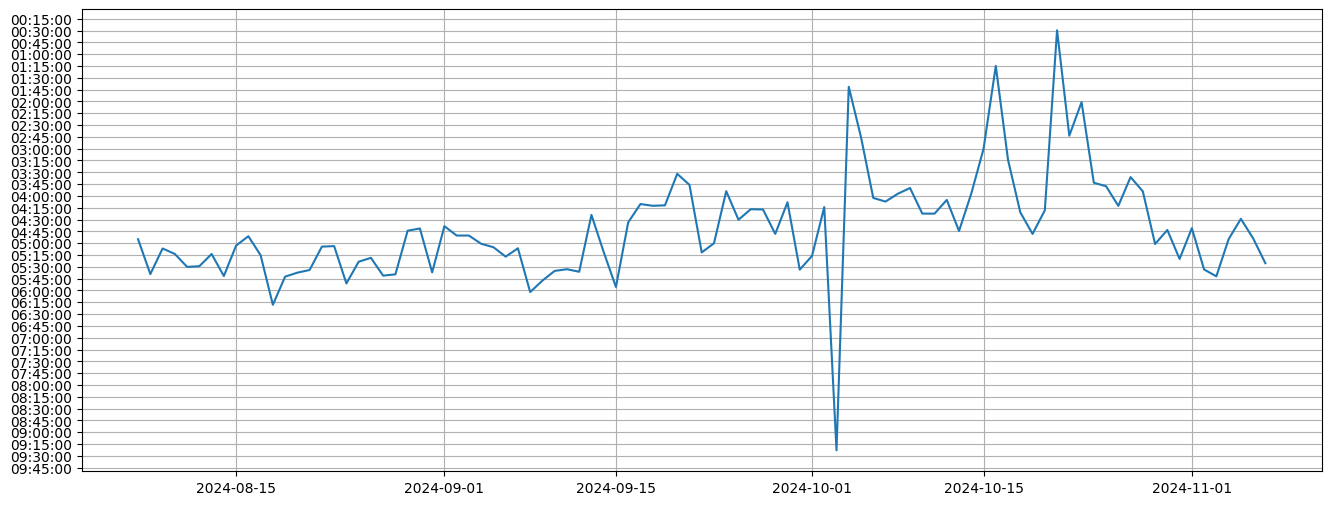

In [12]:
from datetime import datetime, date, time, timedelta
from typing import cast
import matplotlib.pyplot as plt

# 6pm-12pm
late_evening_second_offset = 20 * 3600
late_evening = time(20, 0, 0)

midpoints: list[time] = [t for t in analysis.get_column("midpoint").to_list()]
adjusted_time_offsets = []

for midpoint in midpoints:
    second_offset = (datetime.combine(date.min, midpoint) - datetime.min).total_seconds()

    if midpoint >= time(20, 0, 0):
        adjusted_time_offsets.append(
            -(86400 - late_evening_second_offset) + (second_offset - late_evening_second_offset)
        )
    else:
        adjusted_time_offsets.append(second_offset)

ticks = []
tick_labels = []

for i in range(0, 96):
    dt = datetime.combine(date.min, late_evening) + timedelta(minutes=i*15)
    ticks.append(-(86400 - late_evening_second_offset) + (i*15*60))
    tick_labels.append(dt.time().isoformat(timespec="seconds"))

plt.figure(figsize=(16,6))
ax = plt.gca()
ax.yaxis.set_inverted(True)
plt.yticks(ticks, tick_labels)
plt.grid()
plt.plot(
    analysis.get_column("day"),
    adjusted_time_offsets,
)
plt.show()